Preparing baseline plans and evaluating...
Baseline Equal Plan - avg_wait_time: 330.654 s, avg_stops: 0.7499, GW_score: 0.0083
Baseline Random Plan- avg_wait_time: 463.044 s, avg_stops: 0.7501, GW_score: 0.0083
Evaluating initial population...


100%|██████████| 60/60 [00:11<00:00,  5.01it/s]


Gen 1/60 - Best fit: 0.28812, Mean fit: 0.12919
Gen 10/60 - Best fit: 0.28812, Mean fit: 0.12014
Gen 20/60 - Best fit: 0.28816, Mean fit: 0.12605
Gen 30/60 - Best fit: 0.28818, Mean fit: 0.12299
Gen 40/60 - Best fit: 0.28820, Mean fit: 0.12460
Gen 50/60 - Best fit: 0.28822, Mean fit: 0.12231
Gen 60/60 - Best fit: 0.28823, Mean fit: 0.14066
GA run finished in 668.8s. Best fitness: 0.2882
Best plan metrics:
  avg_wait_time: 395.05366465074684
  avg_queue: 211.42349023339915
  avg_stops_per_vehicle: 0.7497435799025272
  ev_avg_delay: 0.0
  ev_penalty: 0.0
  green_wave_score: 0.008264462809917356

Starting rolling re-optimization (adaptive control) over the hour...
Evaluating initial population...


100%|██████████| 30/30 [00:01<00:00, 21.73it/s]


Gen 1/20 - Best fit: 0.29337, Mean fit: 0.22807
Gen 10/20 - Best fit: 0.29423, Mean fit: 0.22623
Gen 20/20 - Best fit: 0.29541, Mean fit: 0.23109
Window 0-900: best fit 0.2954
Evaluating initial population...


100%|██████████| 30/30 [00:01<00:00, 22.05it/s]


Gen 1/20 - Best fit: 0.28987, Mean fit: 0.23789
Gen 10/20 - Best fit: 0.28995, Mean fit: 0.19501
Gen 20/20 - Best fit: 0.29003, Mean fit: 0.23960
Window 900-1800: best fit 0.2900
Evaluating initial population...


100%|██████████| 30/30 [00:02<00:00, 12.76it/s]


Gen 1/20 - Best fit: 0.29160, Mean fit: 0.22127
Gen 10/20 - Best fit: 0.29216, Mean fit: 0.21494
Gen 20/20 - Best fit: 0.29264, Mean fit: 0.20901
Window 1800-2700: best fit 0.2926
Evaluating initial population...


100%|██████████| 30/30 [00:01<00:00, 21.86it/s]


Gen 1/20 - Best fit: 0.29294, Mean fit: 0.21697
Gen 10/20 - Best fit: 0.29386, Mean fit: 0.22436
Gen 20/20 - Best fit: 0.29473, Mean fit: 0.23722
Window 2700-3600: best fit 0.2947

Final signal timings (seconds) per junction (phases 0-3):
J0: [23.  27.4 15.4 33.3]  (cycle=99.2s)
J1: [31.9 32.5 18.5 37.6]  (cycle=120.5s)
J2: [24.9 15.9 13.9 17.7]  (cycle=72.5s)
J3: [40.8 34.9 39.2 44.4]  (cycle=159.4s)
J4: [37.2 35.8 19.9 22.3]  (cycle=115.2s)
J5: [19.1 13.  29.3 19.3]  (cycle=80.7s)
J6: [40.4 38.8 36.7 28.6]  (cycle=144.5s)
J7: [15.9 27.1 34.8 15.5]  (cycle=93.3s)
J8: [12.6 17.  19.  17.4]  (cycle=66.0s)
J9: [61.8 64.8 56.7 24.4]  (cycle=207.6s)
J10: [24.6 30.1 27.3 26.2]  (cycle=108.2s)
J11: [10.7 50.1 33.5 26.6]  (cycle=120.9s)

Before vs After Metrics:
                  metric  baseline_equal     ga_best      random
0        avg_wait_time_s      330.654197  395.053665  463.043651
1  avg_stops_per_vehicle        0.749940    0.749744    0.750098
2       green_wave_score        0.00826

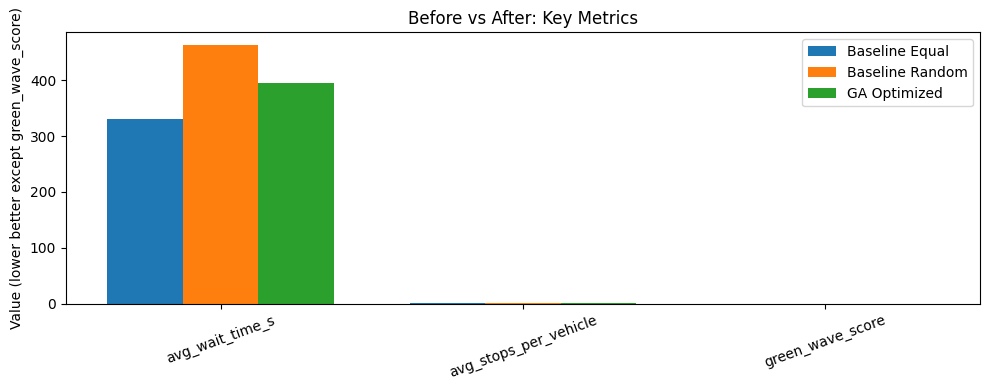

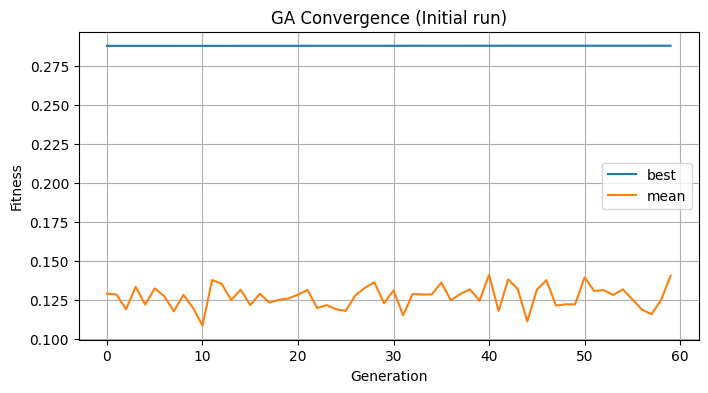

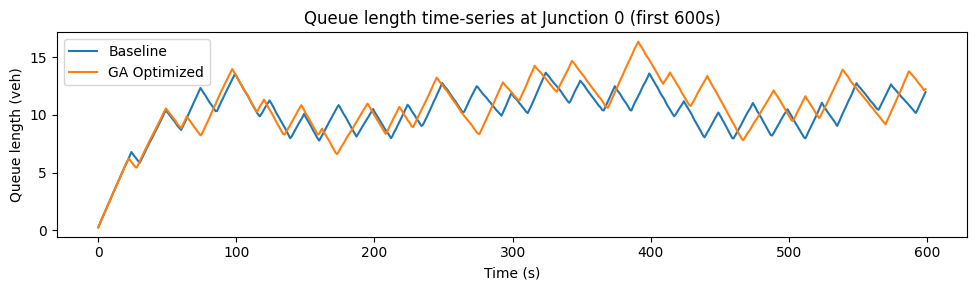

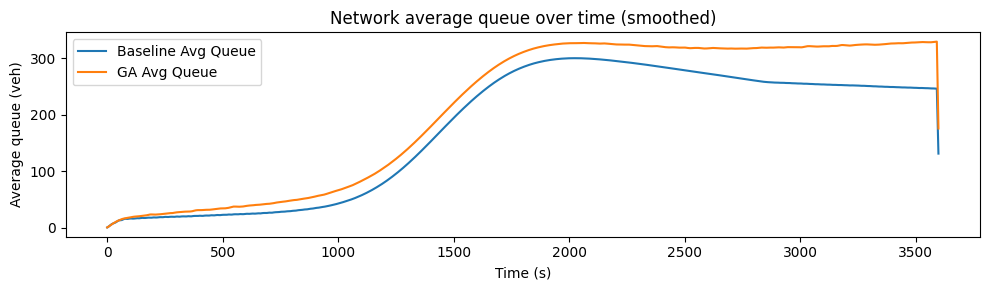


Saved outputs to /content/final_signal_plan.csv and /content/before_after_metrics.csv


In [1]:
!pip install -q tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import random
import time
import math
from collections import deque, defaultdict

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

N_JUNCTIONS = 12
PHASES_PER_JUNCTION = 4
MIN_GREEN = 10
MAX_GREEN = 90
SIM_SECONDS = 3600
TIME_STEP = 1
POPULATION = 60
GENERATIONS = 60
TOURNAMENT = 3
MUT_RATE = 0.18
CX_RATE = 0.75
ROLLING_HORIZON = True
REOPT_HORIZON = 900
ELITE_K = 4


USE_REAL_DATA = False
REAL_DATA_PATH = "/content/arrival_rates.csv"


junction_ids = list(range(N_JUNCTIONS))

corridor = [0, 1, 2, 3, 4]


corridor_link_travel = { (corridor[i], corridor[i+1]): 30 for i in range(len(corridor)-1) }

def generate_synthetic_arrival_profile(sim_seconds=SIM_SECONDS):
    arr = np.zeros((sim_seconds, N_JUNCTIONS, PHASES_PER_JUNCTION), dtype=float)
    t = np.arange(sim_seconds)
    for j in range(N_JUNCTIONS):
        base = 0.08 + 0.02 * (j % 4)
        hump = 0.12 * np.exp(-((t - sim_seconds*0.4)**2) / (2*(sim_seconds*0.08)**2))
        for a in range(PHASES_PER_JUNCTION):
            noise = 0.02 * np.sin(2*np.pi*(t/300.0) + (j+a))
            arr[:, j, a] = np.clip(base + hump + noise + 0.01*np.random.randn(sim_seconds), 0.005, 0.6)
    return arr

def load_real_arrivals(path, sim_seconds=SIM_SECONDS):
    df = pd.read_csv(path)
    arr = np.zeros((sim_seconds, N_JUNCTIONS, PHASES_PER_JUNCTION), dtype=float)
    for _, row in df.iterrows():
        t = int(row['time'])
        j = int(row['junction'])
        a = int(row['approach'])
        if 0 <= t < sim_seconds and 0 <= j < N_JUNCTIONS and 0 <= a < PHASES_PER_JUNCTION:
            arr[t, j, a] = row['arrival_rate']
    return arr

if USE_REAL_DATA:
    arrivals = load_real_arrivals(REAL_DATA_PATH, SIM_SECONDS)
else:
    arrivals = generate_synthetic_arrival_profile(SIM_SECONDS)


class JunctionState:
    def __init__(self, j_id):

        self.queues = [0.0 for _ in range(PHASES_PER_JUNCTION)]

        self.stopped_vehicles = 0.0

    def total_queue(self):
        return sum(self.queues)

def run_simulation(signal_plan, arrivals, sim_seconds=SIM_SECONDS, time_step=TIME_STEP, record_queues=False):
    junctions = [JunctionState(j) for j in range(N_JUNCTIONS)]
    cycles = []
    for j in range(N_JUNCTIONS):
        durations = [max(MIN_GREEN, min(MAX_GREEN, int(round(g)))) for g in signal_plan[j]]
        cycles.append([(p, durations[p]) for p in range(PHASES_PER_JUNCTION)])

    SAT_RATE = 0.5
    total_arrivals = 0.0
    total_wait_time = 0.0
    total_stops = 0.0

    ev_count = 0
    ev_delay_total = 0.0
    ev_penalty = 0.0

    q_ts = np.zeros((sim_seconds, N_JUNCTIONS))
    phase_ptr = [0 for _ in range(N_JUNCTIONS)]
    phase_remaining = [cycles[j][0][1] for j in range(N_JUNCTIONS)]


    offsets = [0]*N_JUNCTIONS

    for t in range(sim_seconds):
        for j in range(N_JUNCTIONS):
            for a in range(PHASES_PER_JUNCTION):
                lam = arrivals[t, j, a]

                arriving = lam * time_step
                junctions[j].queues[a] += arriving
                total_arrivals += arriving

                cur_phase_idx = cycles[j][phase_ptr[j]][0]
                if a != cur_phase_idx:
                    total_stops += arriving


        if random.random() < 0.0008:
            ev_count += 1

            ev_j = random.randrange(N_JUNCTIONS)
            ev_a = random.randrange(PHASES_PER_JUNCTION)

            cur_phase_idx = cycles[ev_j][phase_ptr[ev_j]][0]
            delay = 0
            if ev_a != cur_phase_idx:

                rem = phase_remaining[ev_j]
                idx = phase_ptr[ev_j]
                while True:
                    idx = (idx + 1) % len(cycles[ev_j])
                    rem += cycles[ev_j][idx][1]
                    if cycles[ev_j][idx][0] == ev_a:
                        break
                delay = rem
            ev_delay_total += delay
            ev_penalty += max(0, delay - 10) * 5.0


        for j in range(N_JUNCTIONS):
            phase_idx, _ = cycles[j][phase_ptr[j]]

            served = min(junctions[j].queues[phase_idx], SAT_RATE * time_step)

            total_wait_time += sum(junctions[j].queues) * time_step
            junctions[j].queues[phase_idx] -= served

            phase_remaining[j] -= time_step
            if phase_remaining[j] <= 0:
                phase_ptr[j] = (phase_ptr[j] + 1) % len(cycles[j])
                phase_remaining[j] = cycles[j][phase_ptr[j]][1]

        for j in range(N_JUNCTIONS):
            q_ts[t, j] = junctions[j].total_queue()

    avg_queue = q_ts.mean()
    avg_wait_time = total_wait_time / max(1.0, total_arrivals)
    avg_stops_per_vehicle = total_stops / max(1.0, total_arrivals)
    ev_avg_delay = ev_delay_total / max(1.0, ev_count)

    offsets = []
    for j in range(N_JUNCTIONS):
        durations = [max(MIN_GREEN, min(MAX_GREEN, int(round(g)))) for g in signal_plan[j]]

        offsets.append(0)

    gw_mismatch = 0.0
    for (u, v), travel in corridor_link_travel.items():

        cyc_u = sum(max(MIN_GREEN, min(MAX_GREEN, int(round(g)))) for g in signal_plan[u])
        cyc_v = sum(max(MIN_GREEN, min(MAX_GREEN, int(round(g)))) for g in signal_plan[v])
        cyc = max(60, (cyc_u + cyc_v) / 2.0)
        ideal = (offsets[u] + travel) % cyc
        actual = offsets[v] % cyc
        diff = min(abs(actual - ideal), cyc - abs(actual - ideal))
        gw_mismatch += diff

    gw_score = 1.0 / (1.0 + gw_mismatch)

    metrics = {
        'avg_wait_time': avg_wait_time,
        'avg_queue': avg_queue,
        'avg_stops_per_vehicle': avg_stops_per_vehicle,
        'ev_avg_delay': ev_avg_delay,
        'ev_penalty': ev_penalty,
        'green_wave_score': gw_score,
        'q_ts': q_ts
    }
    return metrics


CHROM_LEN = N_JUNCTIONS * PHASES_PER_JUNCTION

def create_individual():

    indiv = np.zeros(CHROM_LEN)
    idx = 0
    for j in range(N_JUNCTIONS):
        cyc = random.randint(60, 160)

        parts = np.random.dirichlet(np.ones(PHASES_PER_JUNCTION))
        durations = (parts * (cyc - PHASES_PER_JUNCTION*MIN_GREEN)) + MIN_GREEN
        durations = np.clip(durations, MIN_GREEN, MAX_GREEN)
        durations = durations * (cyc / durations.sum())
        for p in range(PHASES_PER_JUNCTION):
            indiv[idx] = durations[p]
            idx += 1
    return indiv

def decode_individual(indiv):

    return indiv.reshape((N_JUNCTIONS, PHASES_PER_JUNCTION))


def fitness_from_metrics(metrics):
    a = metrics['avg_wait_time']
    b = metrics['avg_stops_per_vehicle']
    ev = metrics['ev_penalty']
    gw = metrics['green_wave_score']
    q = metrics['avg_queue']
    w_a = 0.5
    w_b = 0.15
    w_ev = 0.2
    w_gw = 0.15

    score = 0.0
    score += w_a * (1.0 / (1.0 + a))
    score += w_b * (1.0 / (1.0 + b))
    score += w_ev * (1.0 / (1.0 + ev/10.0))
    score += w_gw * gw
    return score

def evaluate_individual(indiv, arrivals, sim_seconds=SIM_SECONDS):
    plan = decode_individual(indiv)
    metrics = run_simulation(plan, arrivals, sim_seconds=sim_seconds)
    fitness = fitness_from_metrics(metrics)
    return fitness, metrics

def tournament_selection(pop, fits, k=TOURNAMENT):
    best = None
    best_idx = None
    for _ in range(k):
        i = random.randrange(len(pop))
        if best is None or fits[i] > best:
            best = fits[i]
            best_idx = i
    return pop[best_idx]

def single_point_crossover(a, b):
    if random.random() > CX_RATE:
        return a.copy(), b.copy()
    pt = random.randrange(1, CHROM_LEN)
    c1 = np.concatenate([a[:pt], b[pt:]])
    c2 = np.concatenate([b[:pt], a[pt:]])
    return c1, c2

def mutate(indiv, mut_rate=MUT_RATE):
    child = indiv.copy()
    for j in range(N_JUNCTIONS):
        for p in range(PHASES_PER_JUNCTION):
            idx = j*PHASES_PER_JUNCTION + p
            if random.random() < mut_rate:

                child[idx] += np.random.normal(0, 6.0)
                child[idx] = float(np.clip(child[idx], MIN_GREEN, MAX_GREEN))

        start = j*PHASES_PER_JUNCTION
        end = start + PHASES_PER_JUNCTION
        seg = child[start:end]
        cyc = max(60, seg.sum())

        seg = seg * (cyc / seg.sum())
        child[start:end] = np.clip(seg, MIN_GREEN, MAX_GREEN)
    return child

def run_GA(arrivals, pop_size=POPULATION, generations=GENERATIONS, sim_seconds=SIM_SECONDS):
    pop = [create_individual() for _ in range(pop_size)]
    fitnesses = []
    metrics_store = [None]*pop_size

    print("Evaluating initial population...")
    for i in tqdm(range(pop_size)):
        f, m = evaluate_individual(pop[i], arrivals, sim_seconds=sim_seconds)
        fitnesses.append(f)
        metrics_store[i] = m
    best_hist = []
    mean_hist = []
    best_metrics = None
    best_ind = None
    best_fit = -1e9

    for g in range(generations):
        new_pop = []
        new_fits = []
        new_metrics = []
        idx_sorted = sorted(range(len(pop)), key=lambda i: fitnesses[i], reverse=True)
        for k in range(ELITE_K):
            i = idx_sorted[k]
            new_pop.append(pop[i].copy())
            new_fits.append(fitnesses[i])
            new_metrics.append(metrics_store[i])

        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fitnesses)
            p2 = tournament_selection(pop, fitnesses)
            c1, c2 = single_point_crossover(p1, p2)
            c1 = mutate(c1)
            c2 = mutate(c2)
            f1, m1 = evaluate_individual(c1, arrivals, sim_seconds=sim_seconds)
            f2, m2 = evaluate_individual(c2, arrivals, sim_seconds=sim_seconds)
            new_pop.append(c1); new_fits.append(f1); new_metrics.append(m1)
            if len(new_pop) < pop_size:
                new_pop.append(c2); new_fits.append(f2); new_metrics.append(m2)

        pop = new_pop
        fitnesses = new_fits
        metrics_store = new_metrics

        gen_best_idx = int(np.argmax(fitnesses))
        gen_best_fit = fitnesses[gen_best_idx]
        gen_mean = np.mean(fitnesses)
        best_hist.append(gen_best_fit)
        mean_hist.append(gen_mean)

        if gen_best_fit > best_fit:
            best_fit = gen_best_fit
            best_ind = pop[gen_best_idx].copy()
            best_metrics = metrics_store[gen_best_idx]

        if (g+1) % 10 == 0 or g == 0:
            print(f"Gen {g+1}/{generations} - Best fit: {gen_best_fit:.5f}, Mean fit: {gen_mean:.5f}")

    return {
        'best_ind': best_ind,
        'best_metrics': best_metrics,
        'best_fit': best_fit,
        'hist_best': best_hist,
        'hist_mean': mean_hist
    }

def create_equal_plan():
    indiv = np.zeros(CHROM_LEN)
    idx = 0
    for j in range(N_JUNCTIONS):
        cyc = 100
        part = cyc / PHASES_PER_JUNCTION
        for p in range(PHASES_PER_JUNCTION):
            indiv[idx] = part
            idx += 1
    return indiv

def create_random_plan():
    indiv = np.zeros(CHROM_LEN)
    idx = 0
    for j in range(N_JUNCTIONS):
        cyc = random.randint(60, 160)
        parts = np.random.dirichlet(np.ones(PHASES_PER_JUNCTION))
        durations = (parts * (cyc - PHASES_PER_JUNCTION*MIN_GREEN)) + MIN_GREEN
        durations = durations * (cyc / durations.sum())
        for p in range(PHASES_PER_JUNCTION):
            indiv[idx] = durations[p]
            idx += 1
    return indiv



print("Preparing baseline plans and evaluating...")

equal_plan = create_equal_plan()
random_plan = create_random_plan()

baseline_eq_fit, baseline_eq_metrics = evaluate_individual(equal_plan, arrivals, sim_seconds=SIM_SECONDS)
baseline_rand_fit, baseline_rand_metrics = evaluate_individual(random_plan, arrivals, sim_seconds=SIM_SECONDS)
print(f"Baseline Equal Plan - avg_wait_time: {baseline_eq_metrics['avg_wait_time']:.3f} s, avg_stops: {baseline_eq_metrics['avg_stops_per_vehicle']:.4f}, GW_score: {baseline_eq_metrics['green_wave_score']:.4f}")
print(f"Baseline Random Plan- avg_wait_time: {baseline_rand_metrics['avg_wait_time']:.3f} s, avg_stops: {baseline_rand_metrics['avg_stops_per_vehicle']:.4f}, GW_score: {baseline_rand_metrics['green_wave_score']:.4f}")

start_time = time.time()
ga_result = run_GA(arrivals, pop_size=POPULATION, generations=GENERATIONS, sim_seconds=SIM_SECONDS)
end_time = time.time()
print(f"GA run finished in {end_time - start_time:.1f}s. Best fitness: {ga_result['best_fit']:.4f}")

best_plan = ga_result['best_ind']
best_metrics = ga_result['best_metrics']

print("Best plan metrics:")
for k,v in best_metrics.items():
    if k != 'q_ts':
        print(f"  {k}: {v}")


if ROLLING_HORIZON:
    print("\nStarting rolling re-optimization (adaptive control) over the hour...")
    horizon = REOPT_HORIZON
    t0 = 0
    current_plan = best_plan.copy()
    adapted_plans = []
    adapted_metrics = []
    while t0 < SIM_SECONDS:
        t1 = min(SIM_SECONDS, t0 + horizon)

        sub_arrivals = arrivals[t0:t1]
        sub_result = run_GA(sub_arrivals, pop_size=30, generations=20, sim_seconds=(t1 - t0))
        adapted_plans.append(sub_result['best_ind'])
        adapted_metrics.append(sub_result['best_metrics'])
        print(f"Window {t0}-{t1}: best fit {sub_result['best_fit']:.4f}")
        t0 = t1

final_plan = best_plan.reshape((N_JUNCTIONS, PHASES_PER_JUNCTION))
print("\nFinal signal timings (seconds) per junction (phases 0-3):")
for j in range(N_JUNCTIONS):
    print(f"J{j}: {np.round(final_plan[j],1)}  (cycle={np.round(final_plan[j].sum(),1)}s)")

metrics_df = pd.DataFrame({
    'metric': ['avg_wait_time_s', 'avg_stops_per_vehicle', 'green_wave_score'],
    'baseline_equal': [baseline_eq_metrics['avg_wait_time'], baseline_eq_metrics['avg_stops_per_vehicle'], baseline_eq_metrics['green_wave_score']],
    'ga_best': [best_metrics['avg_wait_time'], best_metrics['avg_stops_per_vehicle'], best_metrics['green_wave_score']],
    'random': [baseline_rand_metrics['avg_wait_time'], baseline_rand_metrics['avg_stops_per_vehicle'], baseline_rand_metrics['green_wave_score']]
})
print("\nBefore vs After Metrics:")
print(metrics_df)
plt.figure(figsize=(10,4))
x = np.arange(len(metrics_df))
width = 0.25
plt.bar(x - width, metrics_df['baseline_equal'], width, label='Baseline Equal')
plt.bar(x, metrics_df['random'], width, label='Baseline Random')
plt.bar(x + width, metrics_df['ga_best'], width, label='GA Optimized')
plt.xticks(x, metrics_df['metric'], rotation=20)
plt.ylabel('Value (lower better except green_wave_score)')
plt.title('Before vs After: Key Metrics')
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,4))
plt.plot(ga_result['hist_best'], label='best')
plt.plot(ga_result['hist_mean'], label='mean')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('GA Convergence (Initial run)')
plt.legend()
plt.grid(True)
plt.show()

q_before = baseline_eq_metrics['q_ts']
q_after = best_metrics['q_ts']

def plot_queue_time_series(qb, qa, junction_index=0, window=300):
    w = min(window, qb.shape[0])
    t = np.arange(w)
    plt.figure(figsize=(10,3))
    plt.plot(t, qb[:w, junction_index], label='Baseline')
    plt.plot(t, qa[:w, junction_index], label='GA Optimized')
    plt.xlabel('Time (s)')
    plt.ylabel('Queue length (veh)')
    plt.title(f'Queue length time-series at Junction {junction_index} (first {w}s)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_queue_time_series(q_before, q_after, junction_index=0, window=600)


def smooth(x, k=15):
    return np.convolve(x, np.ones(k)/k, mode='same')
avg_q_before = smooth(q_before.mean(axis=1))
avg_q_after = smooth(q_after.mean(axis=1))
plt.figure(figsize=(10,3))
plt.plot(avg_q_before, label='Baseline Avg Queue')
plt.plot(avg_q_after, label='GA Avg Queue')
plt.xlabel('Time (s)')
plt.ylabel('Average queue (veh)')
plt.title('Network average queue over time (smoothed)')
plt.legend()
plt.tight_layout()
plt.show()


out_df = pd.DataFrame(final_plan, columns=[f'phase_{p}' for p in range(PHASES_PER_JUNCTION)])
out_df['junction'] = np.arange(N_JUNCTIONS)
out_df = out_df[['junction'] + [f'phase_{p}' for p in range(PHASES_PER_JUNCTION)]]
out_df.to_csv('/content/final_signal_plan.csv', index=False)
metrics_df.to_csv('/content/before_after_metrics.csv', index=False)
print("\nSaved outputs to /content/final_signal_plan.csv and /content/before_after_metrics.csv")
